In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

Загрузка данных

In [2]:
customers = pd.read_csv('customers.tsv', sep='\t')
sales = pd.read_csv('sales.tsv', sep='\t')

In [3]:
customers.head()

,year,month,ira,customers_type,amount_of_customers
0,2017,1,AC,Archer,679.0
1,2017,1,AC,Monk,1070.0
2,2017,1,AC,Dwarf,610.0
3,2017,1,AC,Centaur,1315.0
4,2017,1,AC,Gremlin,1554.0


In [4]:
sales.head()

,year,month,location,ira,product_category,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,volume,price
0,2017,1,Alpha City,AC,Chocolates,Cadbury,sku #79,1,Standart,No,Nothing,4572.0,NaN
1,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #15,1,Standart,No,Nothing,8028.0,1.221336
2,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #16,3,Standart,No,Nothing,6606.0,2.866401
3,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #22,2,Standart,No,Nothing,11688.0,2.093719
4,2017,1,Alpha City,AC,Chocolates,Ferrero Rocher,sku #28,3,Standart,No,Nothing,3582.0,2.866401


In [5]:
print('Количество уникальных значений:\n sales_ira: {} \n customers_ira: {} \n customers_type: {} \n product_category: {} \n brand: {} \n sku_id: {} \n shape: {} \n with_alcohol: {} \n filling: {}'.format(len(pd.unique(sales['ira'])),len(pd.unique(customers['ira'])),len(pd.unique(customers['customers_type'])),len(pd.unique(sales['product_category'])),len(pd.unique(sales['brand'])),len(pd.unique(sales['sku_id'])),len(pd.unique(sales['shape'])),len(pd.unique(sales['with_alcohol'])),len(pd.unique(sales['filling']))))


Количество уникальных значений:
 sales_ira: 4 
 customers_ira: 3 
 customers_type: 20 
 product_category: 2 
 brand: 7 
 sku_id: 43 
 shape: 3 
 with_alcohol: 2 
 filling: 3


В таблице customers нет данных про локацию Village

In [6]:
city = []
num_of_sku = []
print('Количество уникальных sku_id в городах')
for loc in pd.unique(sales['ira']):
    print(loc+': ' + str(len(pd.unique(sales[sales['ira']==loc].sku_id))))

Количество уникальных sku_id в городах
AC: 24
MN: 33
PB: 26
VL: 4


Проверим наличие пропусков в данных

In [7]:
sales.isnull().sum()

year                  0
month                 0
location              0
ira                   0
product_category      0
brand                 0
sku_id                0
item_per_bundle       0
shape                 0
with_alcohol          0
filling               0
volume                0
price               112
dtype: int64

Добавим столбец time -- номер месяца, начиная с 1
Добавим к каждой записи в sales информацию из customers в этом месяце

In [8]:
#вместо года и месяца -- номер месяца с 1
sales['time'] = (sales['year']-2017)*12+sales['month']
customers['time'] = (customers['year']-2017)*12+customers['month']

#доп столбец ira+номер месяца
sales['loc_time'] = (sales['ira']+sales['time'].astype(str))
customers['loc_time'] = (customers['ira']+customers['time'].astype(str))

sales.drop(['product_category'],axis=1,inplace =True) #product_category!=Chocolates => brand == 'Chupa Chups'

In [9]:
pivoted_customers = customers.pivot(index='loc_time', columns='customers_type', values='amount_of_customers') 

In [10]:
pivoted_customers.head()

customers_type,Angel,Archer,Centaur,Demon,Dwarf,Elf,Gargoyle,Genie,Ghost,Giant,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
loc_time,,,,,,,,,,,,,,,,,,,,
AC1,1527.0,679.0,1315.0,575.0,610.0,5882.0,1268.0,4899.0,1006.0,871.0,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0
AC10,1158.0,852.0,2392.0,1255.0,782.0,6304.0,1692.0,8081.0,1308.0,664.0,698.0,2001.0,567.0,341.0,1085.0,1938.0,1144.0,40221.0,3143.0,11060.0
AC11,1099.0,831.0,1440.0,852.0,596.0,4740.0,1400.0,6190.0,1095.0,569.0,519.0,1674.0,516.0,343.0,887.0,1915.0,975.0,26202.0,2118.0,8563.0
AC12,1495.0,772.0,1222.0,706.0,607.0,5096.0,1481.0,6401.0,1245.0,898.0,569.0,1778.0,522.0,222.0,860.0,1715.0,1236.0,31364.0,2215.0,8995.0
AC13,1495.0,722.0,1620.0,654.0,686.0,6073.0,1387.0,5693.0,1128.0,780.0,479.0,1517.0,544.0,428.0,1124.0,2619.0,1027.0,20347.0,2376.0,9031.0


In [11]:
df = sales.merge(pivoted_customers,how = 'left',on = 'loc_time')

In [12]:
print(df.columns)
df.head()

Index(['year', 'month', 'location', 'ira', 'brand', 'sku_id',
       'item_per_bundle', 'shape', 'with_alcohol', 'filling', 'volume',
       'price', 'time', 'loc_time', 'Angel', 'Archer', 'Centaur', 'Demon',
       'Dwarf', 'Elf', 'Gargoyle', 'Genie', 'Ghost', 'Giant', 'Goblin',
       'Gremlin', 'Medusa', 'Minotaur', 'Monk', 'Orc', 'Pegasus', 'Pirate',
       'Unicorn', 'other'],
      dtype='object')


,year,month,location,ira,brand,sku_id,item_per_bundle,shape,with_alcohol,filling,...,Goblin,Gremlin,Medusa,Minotaur,Monk,Orc,Pegasus,Pirate,Unicorn,other
0,2017,1,Alpha City,AC,Cadbury,sku #79,1,Standart,No,Nothing,...,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0
1,2017,1,Alpha City,AC,Ferrero Rocher,sku #15,1,Standart,No,Nothing,...,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0
2,2017,1,Alpha City,AC,Ferrero Rocher,sku #16,3,Standart,No,Nothing,...,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0
3,2017,1,Alpha City,AC,Ferrero Rocher,sku #22,2,Standart,No,Nothing,...,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0
4,2017,1,Alpha City,AC,Ferrero Rocher,sku #28,3,Standart,No,Nothing,...,399.0,1554.0,441.0,235.0,1070.0,2523.0,1027.0,17465.0,2501.0,8549.0


Построим графики периодов продажи каждой позиции в каждом городе

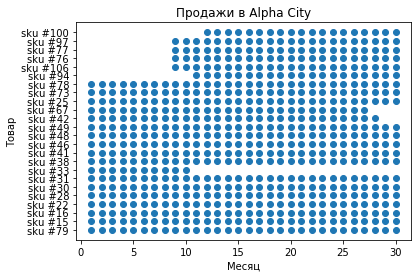

In [13]:
x = []
y = []
for i in pd.unique(df['sku_id']):
    n = len(df[(df.ira=='AC')&(df.sku_id==i)].time)
    x.extend(df[(df.ira=='AC')&(df.sku_id==i)].time.values)
    for j in range(n):
        y.append(i)

fig, ax = plt.subplots()

ax.set_title('Продажи в Alpha City')
ax.set_xlabel('Месяц')
ax.set_ylabel('Товар')
ax.scatter(x,y)
plt.show()

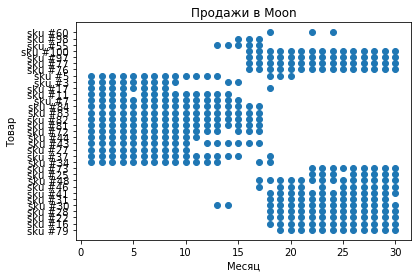

In [14]:
x = []
y = []
for i in pd.unique(df['sku_id']):
    n = len(df[(df.ira=='MN')&(df.sku_id==i)].time)
    x.extend(df[(df.ira=='MN')&(df.sku_id==i)].time.values)
    for j in range(n):
        y.append(i)

fig, ax = plt.subplots()

ax.set_title('Продажи в Moon')
ax.set_xlabel('Месяц')
ax.set_ylabel('Товар')
ax.scatter(x,y)
plt.show()

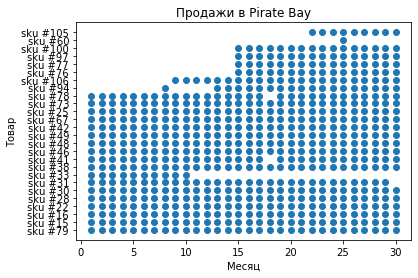

In [15]:
x = []
y = []
for i in pd.unique(df['sku_id']):
    n = len(df[(df.ira=='PB')&(df.sku_id==i)].time)
    x.extend(df[(df.ira=='PB')&(df.sku_id==i)].time.values)
    for j in range(n):
        y.append(i)

fig, ax = plt.subplots()

ax.set_title('Продажи в Pirate Bay')
ax.set_xlabel('Месяц')
ax.set_ylabel('Товар')
ax.scatter(x,y)
plt.show()

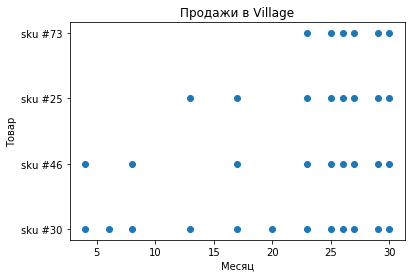

In [16]:
x = []
y = []
for i in pd.unique(df['sku_id']):
    n = len(df[(df.ira=='VL')&(df.sku_id==i)].time)
    x.extend(df[(df.ira=='VL')&(df.sku_id==i)].time.values)
    for j in range(n):
        y.append(i)

fig, ax = plt.subplots()

ax.set_title('Продажи в Village')
ax.set_xlabel('Месяц')
ax.set_ylabel('Товар')
ax.scatter(x,y)
plt.show()

Из графиков можем заметить, что некоторые товары в городах не продаются уже несколько месяцев. Поэтому, будем делать прогноз только для тех товаров, которые продавались в городе хотя бы один раз за последние 2 месяца.
Также можно заметить отсутсятвие сезонных товаров(которые продаются только в определенные месяцы каждый год)

к каждой записи добавим значение price_dif -- как изменилась цена с прошлого раза, volume_dif -- изменение объема продаж и volume_last -- значение объема продаж в прошлый раз

In [17]:
def add_features(df):
    df['price_dif'] = 0
    df['volume_dif'] = 0
    df['volume_last'] = df['volume'].mean()
    #df['volume_year_ago'] = df['volume'].mean()
    
    
    price_dif = [0]
    for i in range(len(df['price'])-1):
        price_dif.append(df['price'].values[i+1]-df['price'].values[i])
    df['price_dif'] = price_dif
    
    volume_dif = [0]
    for i in range(len(df['volume'])-1):
        volume_dif.append(df['volume'].values[i+1]-df['volume'].values[i])
    df['volume_dif'] = volume_dif
    
    volume_last = [df['volume'].values[0]]
    for i in range(len(df['volume'])-1):
        volume_last.append(df['volume'].values[i])
    df['volume_last'] = volume_last

    return df

In [18]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    if denominator.any() == 0:
        return 0
    diff = np.abs(y_true - y_pred) / denominator
    return np.nanmean(diff)

Будем прогнозировать значения объема продаж по информации о цене, клиентам и 3м добавленным признакам, характеризующим динамику изменения объема продаж

In [19]:
def volume_pred(df,location,sku_id):
    df1 = df[(df.location==location)&(df.sku_id==sku_id)].copy()
    ira = df1['ira'].values[0]
    
    #замена пропусков в столбце price на соседние значения 
    df1['price']=df1['price'].fillna(method ='ffill')
    df1['price']=df1['price'].fillna(method ='bfill')
    
    
    price = df1['price'].copy()
    df1.drop(['price'],axis=1,inplace =True)
    df1['price'] = price
    
    df1 = add_features(df1)
    
    y = df1['volume'].copy()
    X = df1.drop(['year','month','location','brand','sku_id','item_per_bundle','shape','with_alcohol','filling','loc_time','ira','volume','time'],axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)
    
    cb_model = CatBoostRegressor(iterations=200,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='SMAPE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_wait=20)
    
    cb_model.fit(X_train, y_train,
             eval_set=(X_test, y_test),
             use_best_model=True,
             verbose=50)
    
    
    pred_test_cat = cb_model.predict(X_test) 
    #значение SMAPE при кросс валидации
    acc = smape(y_test,pred_test_cat)
    print(location + ' ' + sku_id + ' SMAPE = ' + str(acc))
    
    #X_pred - признаки для 3х месяцев значению volume которых нужно спрогнозировать
    pred_loc_time = [ira + str(i) for i in range(31,34)]
    X_pred = pivoted_customers.loc[pred_loc_time,:]
    #значение price и volume с последнего месяца
    X_pred['price'] = X['price'].values[-1]
    X_pred['price_dif'] = 0
    X_pred['volume_dif'] = y.values[-1]-y.values[-2]
    last_volume = y.values[-1]
    X_pred['volume_last'] = y.values[-1]
    volume = []
    #прогнозируем значение для volume 3 раза и меняем значение volume_last на предсказанное
    y_pred = cb_model.predict(X_pred)
    volume.append(y_pred[0])
    for i in range(2):
        X_pred['volume_last'] = y_pred[i]
        X_pred['volume_dif'] = y_pred[i+1]-last_volume
        last_volume = y_pred[i+1]
        y_pred = cb_model.predict(X_pred)
        volume.append(y_pred[i+1])
    print(volume)
    
    df_return = pd.DataFrame(columns=['year','month','location','sku_id','volume','SMAPE'])
    df_return['month'] = np.array([7, 8, 9])
    df_return['year'] = 2019
    df_return['location'] = location
    df_return['sku_id'] = sku_id
    df_return['volume'] = volume
    df_return['SMAPE'] = acc
    return df_return

Прогнозируем значение volume для товаров, которые продавались в каждом городе, кроме Village, за последние 2 месяца

In [20]:
final_df = pd.DataFrame(columns=['year','month','location','sku_id','volume','SMAPE'])
locations = df['location'].unique()
locations = np.delete(locations,-1)
for loc in locations:
    sku_list = df[df['location'] == loc].sku_id.unique()
    for sku in sku_list:
        if len(df[(df.location==loc)&(df.sku_id==sku)&(df.time>28)]) !=0 :
            pred = volume_pred(df,loc,sku)
            final_df = final_df.append(pred)
print(final_df)
        

0:	learn: 23.0782273	test: 35.8347411	best: 35.8347411 (0)	total: 102ms	remaining: 20.3s
50:	learn: 10.7405644	test: 29.3121941	best: 29.3121941 (50)	total: 1.27s	remaining: 3.72s
100:	learn: 5.1563827	test: 26.7169459	best: 26.7169459 (100)	total: 2.33s	remaining: 2.29s
150:	learn: 2.6559531	test: 25.4126670	best: 25.4109327 (149)	total: 3.46s	remaining: 1.12s
199:	learn: 1.3889949	test: 24.9365628	best: 24.9365628 (199)	total: 4.52s	remaining: 0us

bestTest = 24.93656276
bestIteration = 199

Alpha City sku #79 SMAPE = 24.936562758406797
[10627.32606963529, 8279.760410539468, 8215.807924396746]
0:	learn: 22.2794190	test: 28.2814403	best: 28.2814403 (0)	total: 25.9ms	remaining: 5.16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 28.17004441
bestIteration = 6

Shrink model to first 7 iterations.
Alpha City sku #15 SMAPE = 28.170044408335215
[11229.699672713512, 10663.987442801348, 10750.209408256564]
0:	learn: 14.3289578	test: 13.6037089	best: 13.6037089 (0)	total: 1

50:	learn: 17.1183741	test: 17.7524895	best: 17.6741352 (38)	total: 825ms	remaining: 2.41s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 17.57799301
bestIteration = 67

Shrink model to first 68 iterations.
Alpha City sku #106 SMAPE = 17.577993007262016
[2882.8385598273235, 2509.148509293083, 2538.4765597719497]
0:	learn: 37.6521195	test: 23.9254361	best: 23.9254361 (0)	total: 14.2ms	remaining: 2.83s
50:	learn: 18.6755815	test: 18.3883656	best: 18.3883656 (50)	total: 893ms	remaining: 2.61s
100:	learn: 8.5598967	test: 14.3281413	best: 14.3281413 (100)	total: 1.75s	remaining: 1.71s
150:	learn: 4.3687008	test: 12.7176902	best: 12.7176902 (150)	total: 2.59s	remaining: 842ms
199:	learn: 2.3441839	test: 12.3177526	best: 12.3177526 (199)	total: 3.41s	remaining: 0us

bestTest = 12.31775257
bestIteration = 199

Alpha City sku #76 SMAPE = 12.317752566896338
[2857.652938031394, 2417.7021507519726, 2437.725350340538]
0:	learn: 34.7403358	test: 24.6823646	best: 24.6823646 (0)	tot

50:	learn: 10.8458046	test: 16.2888177	best: 16.1843862 (46)	total: 573ms	remaining: 1.67s
100:	learn: 5.5136714	test: 14.5485526	best: 14.5485526 (100)	total: 1.23s	remaining: 1.2s
150:	learn: 2.9205343	test: 13.8104380	best: 13.8104380 (150)	total: 1.88s	remaining: 611ms
199:	learn: 1.5844112	test: 13.5122048	best: 13.5059958 (197)	total: 2.52s	remaining: 0us

bestTest = 13.5059958
bestIteration = 197

Shrink model to first 198 iterations.
Moon sku #41 SMAPE = 13.50599580032017
[1176.8104294565055, 981.3337954395865, 922.7724061009822]
0:	learn: 31.4388383	test: 53.8465200	best: 53.8465200 (0)	total: 13.5ms	remaining: 2.69s
50:	learn: 15.7361530	test: 47.3206766	best: 47.3206766 (50)	total: 588ms	remaining: 1.72s
100:	learn: 8.0053429	test: 44.5188153	best: 44.5188153 (100)	total: 1.2s	remaining: 1.18s
150:	learn: 4.1481461	test: 43.8746400	best: 43.8746400 (150)	total: 1.81s	remaining: 586ms
199:	learn: 2.2353913	test: 43.7430894	best: 43.7430894 (199)	total: 2.37s	remaining: 0us

b

50:	learn: 12.4913268	test: 16.6160673	best: 16.4371339 (47)	total: 968ms	remaining: 2.83s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.32744134
bestIteration = 64

Shrink model to first 65 iterations.
Pirate Bay sku #67 SMAPE = 16.327441344807596
[345.57928570683833, 400.28734673071654, 393.8019346919376]
0:	learn: 20.6608240	test: 16.9897023	best: 16.9897023 (0)	total: 11.2ms	remaining: 2.23s
50:	learn: 9.2816902	test: 16.5784851	best: 16.0167639 (32)	total: 917ms	remaining: 2.68s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 16.01676387
bestIteration = 32

Shrink model to first 33 iterations.
Pirate Bay sku #25 SMAPE = 16.016763867354886
[3229.9730010256717, 2852.91618122703, 2867.3750359371115]
0:	learn: 15.9363285	test: 18.7324827	best: 18.7324827 (0)	total: 20.2ms	remaining: 4.02s
50:	learn: 7.6422229	test: 14.2334917	best: 14.2334917 (50)	total: 952ms	remaining: 2.78s
100:	learn: 3.4570445	test: 11.9648382	best: 11.9648382 (100)	total:

Значения метрики, полученые при кросс валидации по каждому из товаров:

In [21]:
final_df.SMAPE.describe()

count    180.000000
mean      21.622593
std       15.174387
min        6.088205
25%       12.293615
50%       17.012352
75%       26.306182
max      101.525083
Name: SMAPE, dtype: float64

Сохранение результатов в tsv файл

In [22]:
final_df.drop(['SMAPE'],axis=1,inplace =True)


In [23]:
final_df.to_csv('result.tsv',sep='\t',index = False)